# Промышленность

__План выполнения работы:__  

1. Предобработка данных (поиск и удаление аномалий, заполнение пропусков) и добавление признаков (суммарное время нагрева электродами, количество запусков нагрева и пр)  
2. Объединить таблицы по ключевому номеру партии в столбцах "key"  
3. Разделение данных на тренировочную и тестовую выборки, обучение моделей.  
4. Сравнение результов на тестовой выборке.

 ## Загрузка и исследование данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Чтение файлов и создание функции для просмотра информации, хранящейся в них.

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

def view(data):
    display(data.head())
    print()
    display(data.info())
    print()
    print('Количество пропусков в файле:')
    display(data.isnull().sum())
    print('Количество данных в файле:', data['key'].value_counts().shape[0])

In [3]:
print('Данные об электродах')
view(data_arc)

Данные об электродах


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None


Количество пропусков в файле:


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Количество данных в файле: 3214


In [4]:
print('Данные о подаче сыпучих материалов (объём)')
view(data_bulk)

Данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


Количество пропусков в файле:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Количество данных в файле: 3129


In [5]:
print('Данные о подаче сыпучих материалов (время)')
view(data_bulk_time)

Данные о подаче сыпучих материалов (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None


Количество пропусков в файле:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Количество данных в файле: 3129


In [6]:
print('Данные о продувке сплава газом')
view(data_gas)

Данные о продувке сплава газом


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


Количество пропусков в файле:


key      0
Газ 1    0
dtype: int64

Количество данных в файле: 3239


In [7]:
print('Результаты измерения температуры')
view(data_temp)

Результаты измерения температуры


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None


Количество пропусков в файле:


key                0
Время замера       0
Температура     2901
dtype: int64

Количество данных в файле: 3216


In [8]:
data_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

Судя по среднему значению и квантилям - в данных есть партии с температурой значительно меньше остальных партий.

In [9]:
display(data_temp.query('Температура < 1400'))

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


<AxesSubplot:>

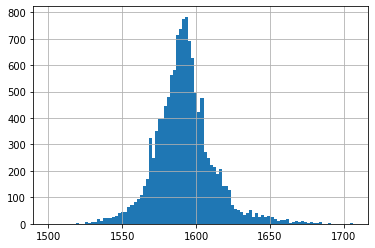

In [10]:
data_temp['Температура'].hist(bins=100,range=(1500,1706))

У большинства партий температура колеблется в диапазоне 1550-1630, у гистограммы распределение нормальное.

<AxesSubplot:>

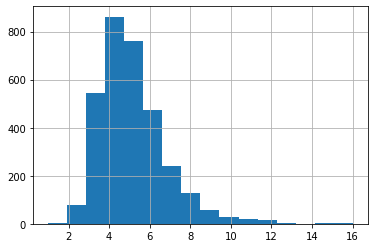

In [11]:
data_temp['key'].value_counts().hist(bins=16)

В данных есть партии с одним замером температуры - их нужно будет удалить, ведь если замер только один - значит в партию ничего не добавляли, или добавляли, но после этого не измерили температуру. Значит такие партии - выбросы.

In [12]:
print('Данные о проволочных материалах (объём)')
view(data_wire)

Данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


Количество пропусков в файле:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Количество данных в файле: 3081


In [13]:
print('Данные о проволочных материалах (время)')
view(data_wire_time)

Данные о проволочных материалах (время)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None


Количество пропусков в файле:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Количество данных в файле: 3081


__Вывод__  

1. В данных очень много отсутствующих значений, которые говорят скорее всего о том, что на данной стадии не добавлялись никакие материалы или что не проводились замеры. Многие пропуски можно заменить на 0.  
2. В таблицах различное количество данных.  

## Предобработка данных

Создание таблицы отдельной с начальной температурой

In [14]:
first_time_meas = pd.pivot_table(data_temp,
                            index=['key'],
                            values=['Время замера'],
                            aggfunc='first')
first_time_meas = first_time_meas.merge(data_temp, on='Время замера')
first_time_meas = first_time_meas.rename(columns={'Температура': 'Начальная тем-ра'})
display(first_time_meas.head())

,Время замера,key,Начальная тем-ра
0,2019-05-03 11:16:18,1,1571.0
1,2019-05-03 11:37:27,2,1581.0
2,2019-05-03 12:13:17,3,1596.0
3,2019-05-03 12:52:57,4,1601.0
4,2019-05-03 13:23:19,5,1576.0


Создание отдельной таблицы с конечной температурой

In [15]:
last_time_meas = pd.pivot_table(data_temp,
                            index=['key'],
                            values=['Время замера'],
                            aggfunc='last')
last_time_meas = last_time_meas.merge(data_temp, on='Время замера')
last_time_meas = last_time_meas.rename(columns={'Температура': 'Конечная тем-ра'})
display(last_time_meas.head())

,Время замера,key,Конечная тем-ра
0,2019-05-03 11:30:39,1,1613.0
1,2019-05-03 11:59:12,2,1602.0
2,2019-05-03 12:34:57,3,1599.0
3,2019-05-03 12:59:25,4,1625.0
4,2019-05-03 13:36:01,5,1602.0


Создание таблицы с начальной и конечной температурой и удаление партий с одним замером.

In [16]:
first_last_time = first_time_meas.merge(last_time_meas, on='key').drop(['Время замера_x','Время замера_y'], axis=1)
first_last_time = first_last_time.dropna().set_index('key')
display(first_last_time.tail())

,Начальная тем-ра,Конечная тем-ра
key,,
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0
2498,1591.0,1594.0
2499,1569.0,1603.0


Создание признаков с длителностью нагрева и с полной мощностью.  
Полная мощность вычисляется по формуле  $$ S = \sqrt {P^2 + Q^2} $$  
где _S_ - полная мощность, а _P_ и _Q_ - активная и реактивная мощности

In [17]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [18]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239


In [19]:
data_arc_exc = data_arc[['key', 'Время нагрева', 'Полная мощность']]
data_arc_exc = pd.pivot_table(data_arc_exc,
                             index='key',
                             values=['Время нагрева','Полная мощность'],
                             aggfunc='sum')
data_arc_exc.head()

,Время нагрева,Полная мощность
key,,
1,1098,5.826395
2,811,3.649216
3,655,2.989534
4,741,3.814962
5,869,4.035758


Создание таблицы, в которую войдут все партии из данных, что нужны для обучения моделей и со всеми новыми признаками.

In [20]:
data_full = first_last_time.merge(data_arc_exc, on='key')

In [21]:
data_full = data_full.merge(data_bulk, on='key')
data_full = data_full.merge(data_gas, on='key')
data_full = data_full.merge(data_wire, on='key')
data_full = data_full.fillna(0).set_index('key')

data_full.rename(columns={'Bulk 1_x':'Bulk 1','Bulk 2_x':'Bulk 2','Bulk 3_x':'Bulk 3','Bulk 4_x':'Bulk 4','Bulk 5_x':'Bulk 5',
                         'Bulk 6_x':'Bulk 6','Bulk 7_x':'Bulk 7','Bulk 8_x':'Bulk 8','Bulk 9_x':'Bulk 9','Bulk 10_x':'Bulk 10',
                         'Bulk 11_x':'Bulk 11','Bulk 12_x':'Bulk 12','Bulk 13_x':'Bulk 13','Bulk 14_x':'Bulk 14',
                          'Bulk 15_x':'Bulk 15','Bulk 16_x':'Bulk 16','Газ 1_y':'Газ','Wire 1_y':'Wire 1',
                         'Wire 2_y':'Wire 2','Wire 3_y':'Wire 3','Wire 4_y':'Wire 4','Wire 5_y':'Wire 5',
                         'Wire 6_y':'Wire 6','Wire 7_y':'Wire 7','Wire 8_y':'Wire 8','Wire 9_y':'Wire 9'})
data_full.head(3)

,Начальная тем-ра,Конечная тем-ра,Время нагрева,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,1098,5.826395,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,811,3.649216,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,655,2.989534,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
data_full['Wire 5'].value_counts()

0.0    2329
Name: Wire 5, dtype: int64

В столец __'Wire 5'__ пустой, удалю его.

In [23]:
data_full = data_full.drop('Wire 5', axis=1)

Для проверки таблицы на мультиколинеарность построю матрицу корелляции.

In [24]:
#data_plot = sns.heatmap(data_full.corr(), cmap="YlGnBu", annot=True)
#plt.show()
data_full.corr()

,Начальная тем-ра,Конечная тем-ра,Время нагрева,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
Начальная тем-ра,1.000000,0.252443,-0.305086,-0.046620,0.072331,0.119802,-0.104394,0.144775,0.068389,-0.096951,...,-0.040349,0.037341,0.209444,-0.086089,-0.000178,0.064991,0.019884,0.044771,-0.023261,0.004310
Конечная тем-ра,0.252443,1.000000,0.278576,0.004379,-0.075206,-0.082454,-0.035977,0.187970,-0.028355,-0.181816,...,0.266414,0.059160,0.317575,-0.206672,-0.047537,-0.159719,-0.084034,-0.137262,-0.010767,-0.027488
Время нагрева,-0.305086,0.278576,1.000000,0.094792,0.103027,0.038213,0.092612,-0.028329,0.013519,0.161907,...,0.295711,0.396379,0.055419,0.054481,0.033399,0.054803,0.042288,0.027620,0.017875,-0.011585
Полная мощность,-0.046620,0.004379,0.094792,1.000000,0.005544,0.003178,-0.001364,-0.016960,-0.001068,0.060496,...,0.009240,0.044966,-0.008369,-0.004323,0.001677,0.005749,0.004208,0.002538,0.001547,-0.003652
Bulk 1,0.072331,-0.075206,0.103027,0.005544,1.000000,0.224701,-0.011628,0.041846,0.060429,-0.003630,...,-0.000800,0.234141,0.013682,-0.009229,0.020271,0.146301,0.148561,0.083443,-0.019535,0.011066
Bulk 2,0.119802,-0.082454,0.038213,0.003178,0.224701,1.000000,-0.046888,0.040792,0.360302,-0.029984,...,-0.105693,0.217415,-0.169477,-0.039058,0.223202,0.699342,0.558889,0.431737,-0.005273,-0.006842
Bulk 3,-0.104394,-0.035977,0.092612,-0.001364,-0.011628,-0.046888,1.000000,-0.295431,-0.006801,0.065284,...,-0.012860,0.059628,0.039637,0.095723,0.005780,-0.040526,0.007113,-0.019448,0.004846,0.004621
Bulk 4,0.144775,0.187970,-0.028329,-0.016960,0.041846,0.040792,-0.295431,1.000000,0.028348,-0.251562,...,0.101514,0.017578,0.297591,-0.268142,-0.039219,0.034421,-0.011417,0.033829,0.007830,-0.058138
Bulk 5,0.068389,-0.028355,0.013519,-0.001068,0.060429,0.360302,-0.006801,0.028348,1.000000,-0.021852,...,-0.067190,0.086902,-0.013493,-0.013794,0.070916,0.262763,0.204819,0.172141,-0.008337,-0.010817
Bulk 6,-0.096951,-0.181816,0.161907,0.060496,-0.003630,-0.029984,0.065284,-0.251562,-0.021852,1.000000,...,-0.109316,0.139625,-0.235793,0.204627,-0.046518,-0.025915,-0.020223,-0.012437,-0.028440,-0.013335


Сильной зависимости между данными не обнаружено.

In [25]:
data_full

,Начальная тем-ра,Конечная тем-ра,Время нагрева,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,1098,5.826395,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,811,3.649216,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,655,2.989534,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,741,3.814962,0.0,0.0,0.0,81.0,0.0,0.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,869,4.035758,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,723,3.986869,0.0,0.0,21.0,0.0,0.0,0.0,...,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2496,1554.0,1591.0,940,5.057033,0.0,0.0,0.0,63.0,0.0,0.0,...,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2497,1571.0,1589.0,569,2.885017,0.0,0.0,0.0,85.0,0.0,0.0,...,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение моделей

Разделение данных на обучающую и тестовую выборки, выделение целевого признака.

In [26]:
df_train1, df_test1 = train_test_split(data_full, test_size=0.20, random_state=20220808)

features_train1 = df_train1.drop(['Конечная тем-ра'], axis=1)
target_train1 = df_train1['Конечная тем-ра']

features_test1 = df_test1.drop(['Конечная тем-ра'], axis=1)
target_test1 = df_test1['Конечная тем-ра']

Добавление метода для оценки точности классификатора и кросс-валидации, добавление словаря

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=20220808)

models_result1 = {}

### LinearRegression

In [28]:
%%time

model_lr1 = LinearRegression()
model_lr1 = model_lr1.fit(features_train1, target_train1)
predictions1 = model_lr1.predict(features_train1)
mae_train_lr1 = mean_absolute_error(target_train1, predictions1)

print('MAE обучающей выборки:', mae_train_lr1)

models_result1['LinearRegression'] = [mae_train_lr1, '52.4 ms']

MAE обучающей выборки: 6.5961250532628055
CPU times: user 19.8 ms, sys: 18 ms, total: 37.8 ms
Wall time: 14.5 ms


### DecisionTreeRegressor

In [29]:
%%time

model_dtr1 = DecisionTreeRegressor(max_depth=5, random_state=12345)
model_dtr1.fit(features_train1, target_train1)
                

predictions_train1 = model_dtr1.predict(features_train1)

mae_train_dtr1 = mean_absolute_error(target_train1, predictions_train1)

display("MAE обучающей выборки:", mae_train_dtr1)

models_result1['DecisionTreeRegressor'] = [mae_train_dtr1, '13.9 ms']

'MAE обучающей выборки:'

6.3122875349341205

CPU times: user 38.8 ms, sys: 46.4 ms, total: 85.2 ms
Wall time: 101 ms


### CatBoostRegressor

In [30]:
parameters = {'max_depth': range(3, 4), #range(3, 10),
              'iterations': np.arange(300, 401, 100), #np.arange(300, 701, 100),
              'learning_rate': np.arange(0.07, 0.11, 0.03) #np.arange(0.01, 0.14, 0.03)
             }

model_cb_gs1 = GridSearchCV(CatBoostRegressor(random_state=20220808), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

model_cb_gs1.fit(features_train1, target_train1)

0:	learn: 11.3163704	total: 47.4ms	remaining: 14.2s
1:	learn: 11.1887627	total: 49.1ms	remaining: 7.31s
2:	learn: 11.0515875	total: 50.6ms	remaining: 5s
3:	learn: 10.9199140	total: 52.1ms	remaining: 3.85s
4:	learn: 10.8424949	total: 53.1ms	remaining: 3.13s
5:	learn: 10.7687084	total: 54.2ms	remaining: 2.65s
6:	learn: 10.6972061	total: 55.3ms	remaining: 2.31s
7:	learn: 10.5955011	total: 56.6ms	remaining: 2.07s
8:	learn: 10.4915923	total: 57.8ms	remaining: 1.87s
9:	learn: 10.3925812	total: 58.9ms	remaining: 1.71s
10:	learn: 10.3080116	total: 60.6ms	remaining: 1.59s
11:	learn: 10.2219974	total: 62.2ms	remaining: 1.49s
12:	learn: 10.1315438	total: 63.7ms	remaining: 1.41s
13:	learn: 10.0557785	total: 65.2ms	remaining: 1.33s
14:	learn: 9.9846996	total: 66.8ms	remaining: 1.27s
15:	learn: 9.9129353	total: 68.3ms	remaining: 1.21s
16:	learn: 9.8680147	total: 69.9ms	remaining: 1.16s
17:	learn: 9.8167948	total: 71.5ms	remaining: 1.12s
18:	learn: 9.7570251	total: 72.6ms	remaining: 1.07s
19:	learn: 

GridSearchCV(cv=KFold(n_splits=5, random_state=20220808, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f002d120550>,
             param_grid={'iterations': array([300, 400]),
                         'learning_rate': array([0.07, 0.1 ]),
                         'max_depth': range(3, 4)},
             scoring='neg_mean_absolute_error', verbose=False)

In [31]:
print(model_cb_gs1.best_params_)

{'iterations': 300, 'learning_rate': 0.1, 'max_depth': 3}


In [32]:
%%time

model_cb1 = CatBoostRegressor(loss_function="MAE", iterations=300, learning_rate = 0.07, max_depth=3, verbose = False)
model_cb1.fit(features_train1, target_train1)

predictions_train1 = model_cb1.predict(features_train1)

mae_train_cb1 = mean_absolute_error(target_train1, predictions_train1)

display("MAE обучающей выборки:", mae_train_cb1)

models_result1['CatBoostRegressor'] = [mae_train_cb1, '1.02 s']

'MAE обучающей выборки:'

5.258968101793271

CPU times: user 343 ms, sys: 28.1 ms, total: 371 ms
Wall time: 740 ms


### Модель LGBMRegressor

In [33]:
parameters = {'max_depth': range(3, 5), #range(2, 11),
             'n_estimators': range(56, 58)}#range(2, 60)}

model_lgbm_gs1 = GridSearchCV(LGBMRegressor(random_state=20220808), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

model_lgbm_gs1.fit(features_train1, target_train1)

GridSearchCV(cv=KFold(n_splits=5, random_state=20220808, shuffle=True),
             estimator=LGBMRegressor(random_state=20220808),
             param_grid={'max_depth': range(3, 5),
                         'n_estimators': range(56, 58)},
             scoring='neg_mean_absolute_error', verbose=False)

In [34]:
display(model_lgbm_gs1.best_params_)

{'max_depth': 3, 'n_estimators': 57}

In [35]:
%%time

model_lgbm1 = LGBMRegressor(max_depth=4, n_estimators=57, random_state=20220808)
model_lgbm1.fit(features_train1, target_train1)

predictions_train1 = model_lgbm1.predict(features_train1)


mae_train_lgbm1 = mean_absolute_error(target_train1, predictions_train1)

display("MAE обучающей выборки:", mae_train_lgbm1)

models_result1['LGBMRegressor'] = [mae_train_lgbm1,  '200 ms']

'MAE обучающей выборки:'

5.2839959193672

CPU times: user 270 ms, sys: 3.32 ms, total: 273 ms
Wall time: 200 ms


## Результаты

In [36]:
data_models1 = pd.DataFrame.from_dict(data=models_result1, columns=['MAE_train', 'time'], orient='index')
display(data_models1)

,MAE_train,time
LinearRegression,6.596125,52.4 ms
DecisionTreeRegressor,6.312288,13.9 ms
CatBoostRegressor,5.258968,1.02 s
LGBMRegressor,5.283996,200 ms


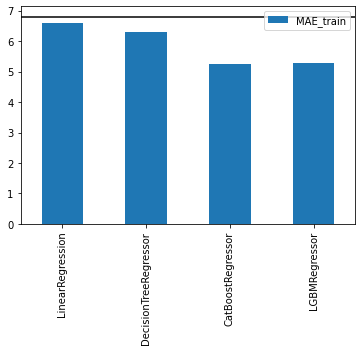

In [37]:
data_models1.plot.bar(stacked=False).hlines(6.8, -5, 10, color='k')

Лучшую метрику MAE на валидационной выборке показала модель CatBoostRegressor. Проверим на тестовых данных.

In [38]:
model_cb1 = CatBoostRegressor(loss_function="MAE", iterations=300, learning_rate = 0.07, max_depth=3, verbose = False)
model_cb1.fit(features_train1, target_train1)

predictions_test1 = model_cb1.predict(features_test1)
mae_test_cb2 = mean_absolute_error(target_test1, predictions_test1)
display("MAE тестовой выборки CatBoostRegressor:", mae_test_cb2)

'MAE тестовой выборки CatBoostRegressor:'

5.442627015704432

Анализ важности признаков у модели CatBoostRegressor

Text(0.5, 1.0, 'Важность признаков CatBoostRegressor')

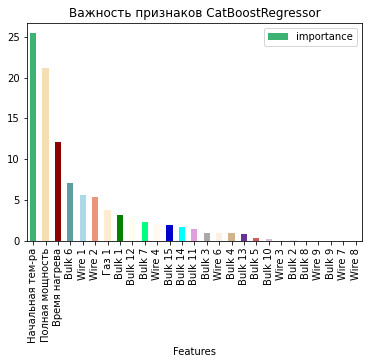

In [39]:
all_colors = list(plt.cm.colors.cnames.keys())
c = random.choices(all_colors, k=28)
importance_cb1 = (pd.DataFrame({'feature': features_train1.columns, 'importance': model_cb1.feature_importances_})
             .sort_values(by='importance', ascending=False).reset_index())
importance_cb1.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), color=c, sharex=False)
plt.xlabel('Features')
plt.title('Важность признаков CatBoostRegressor')

Лучшую метрику MAE показала модель CatBoostRegressor, однако модель LGBMRegressor лишь немногим хуже метрика.  
Посмотрим на MAE на тестовой выборке и анализ важности признаков у LGBMRegressor.

Рассчет MAE на тестовой выборке:

In [40]:
predictions_test1 = model_lgbm1.predict(features_test1)

mae_train_lgbm2 = mean_absolute_error(target_test1, predictions_test1)

display("MAE обучающей выборки:", mae_train_lgbm2)

'MAE обучающей выборки:'

5.670684610136661

Text(0.5, 1.0, 'Важность признаков LGBMRegressor')

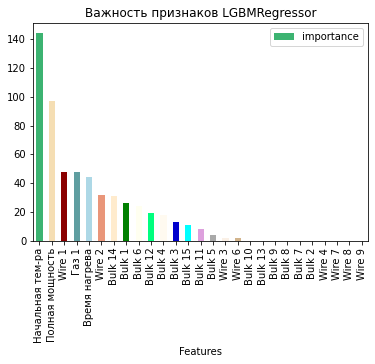

In [41]:
importance_lgbm1 = (pd.DataFrame({'feature': features_train1.columns, 'importance': model_lgbm1.feature_importances_})
             .sort_values(by='importance', ascending=False).reset_index())
importance_lgbm1.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), color=c, sharex=False)
plt.xlabel('Features')
plt.title('Важность признаков LGBMRegressor')

Лучшая модель CatBoostRegressor c MAE = 5.44 на тестовой выборке
У модели LGBMRegressor MAE = 5.67 на тестовой выборке

## Вывод

В данной проектной работе:  
- Были загружены и проанализированы данные из нескольких источников, найдены аномалии.  
- Объединены данные в единую таблицу по ключевому столбцу 'key'.  
- Заполнены пропуска и удалены данные с отсутствующим целевым признаком.  
- Данные были разделены на обучающую, валидационную и тестовую выборки.  
- Обучены 4 модели, такие как:
 - LinearRegression	 
 - DecisionTreeRegressor  
 - CatBoostRegressor  
 - LGBMRegressor  
- Лучшей значение метрики MAE показала модель __CatBoostRegressor__, MAE на тестовой выборке = 5.44.  
  Данное значение метрики получилось достичь при:  
       - iterations=300  
       - learning_rate = 0.07  
       - max_depth=3  
- Был проведен анализ важности признаков у модели-победителя. Наиболее важными факторами, вляющими на модель, являются  
 - Начальная температура  
 - Полная мощность  
 - Время нагрева